In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2
import utils
import dataset_utils

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import dataset_utils

IMG_H = 160
IMG_W = 160
n_train = 5000
n_val = 500
n_test = 1000

batch_size = 24
num_workers = 2

In [3]:
dataset = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Train')

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [11]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

Cloning into 'vision'...
fatal: not a git repository (or any of the parent directories): .git
"cp" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"cp" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"cp" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"cp" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"cp" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [7]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
dataset = dataset_ut. Segmentation_Dataset('../Segmentation_Data/Train', get_transform(train=True))
dataset_test = dataset_ut. Segmentation_Dataset('../Segmentation_Data/Train', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 7

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/4975]  eta: 17:22:13  lr: 0.000010  loss: 5.7219 (5.7219)  loss_classifier: 2.3785 (2.3785)  loss_box_reg: 0.5415 (0.5415)  loss_mask: 2.3585 (2.3585)  loss_objectness: 0.4293 (0.4293)  loss_rpn_box_reg: 0.0141 (0.0141)  time: 12.5695  data: 9.4450  max mem: 1722
Epoch: [0]  [  10/4975]  eta: 2:13:48  lr: 0.000060  loss: 5.3781 (5.2717)  loss_classifier: 2.2406 (2.1970)  loss_box_reg: 0.5869 (0.6087)  loss_mask: 2.1270 (2.1002)  loss_objectness: 0.3562 (0.3460)  loss_rpn_box_reg: 0.0185 (0.0198)  time: 1.6170  data: 0.8600  max mem: 2251
Epoch: [0]  [  20/4975]  eta: 1:31:28  lr: 0.000110  loss: 4.1700 (4.4004)  loss_classifier: 1.6899 (1.7789)  loss_box_reg: 0.7034 (0.7008)  loss_mask: 1.6358 (1.6764)  loss_objectness: 0.1751 (0.2272)  loss_rpn_box_reg: 0.0157 (0.0170)  time: 0.5346  data: 0.0015  max mem: 2375


ValueError: All bounding boxes should have positive height and width. Found invalid box [165.0, 555.0, 165.0, 605.0] for target at index 0.

In [52]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

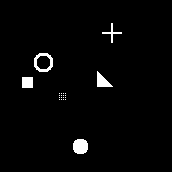

In [53]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [57]:
for i in range(0,6):
    Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())

<PIL.Image.Image image mode=L size=172x172 at 0x13660ABF9D0>
<PIL.Image.Image image mode=L size=172x172 at 0x136063E28B0>
<PIL.Image.Image image mode=L size=172x172 at 0x13660ABF9D0>
<PIL.Image.Image image mode=L size=172x172 at 0x136063E2D90>
<PIL.Image.Image image mode=L size=172x172 at 0x13679483610>
<PIL.Image.Image image mode=L size=172x172 at 0x136063E28B0>


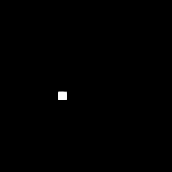

In [77]:
Image.fromarray(prediction[0]['masks'][, 0].mul(255).byte().cpu().numpy())